In [1]:
import os
import json
import cv2
import random              as rd
import numpy               as np
import matplotlib.pyplot   as plt
import matplotlib.patches  as patches

from   glob   import glob
from   PIL    import Image

# custom functions
import Utils               as ut

# Dataset preparation

In [3]:
# important paths, modify them to match with your working folders

folder            = '/Volumes/HDD/WORK/Programming Projects/Network-Detection/'   # working folder
json_folder_path  = folder + 'Sloth_3fish_annotation/'                                   # annotations path

Annotations are stored in .json files.

In [4]:
with open(json_folder_path + '2305_denity_DATA_1405_1.json', 'r') as file:
    data = json.load(file)

n = len(data)                 # visualize manually some files
for i in range(n):
   print(data[i]['filename'])

Data\_frames_1405_cowboyhills\recid3-14-01d_mp4\rectified_auto_resolution\00006010.jpg
Data\_frames_1405_cowboyhills\recid3-14-01d_mp4\rectified_auto_resolution\00012010.jpg
Data\_frames_1405_cowboyhills\recid3-14-01d_mp4\rectified_auto_resolution\00018010.jpg
Data\_frames_1405_cowboyhills\recid3-14-01d_mp4\rectified_auto_resolution\00024010.jpg
Data\_frames_1405_cowboyhills\recid3-14-01d_mp4\rectified_auto_resolution\00030110.jpg


In order to easily access the annotations we save them in the dictionary `image_annotations`.
 The latter takes as keys the images paths and for each image it stores the head/tail position of all the labeled fishes in that image. (There are in total 193.884 labeled fishes) 

In [5]:
json_files = glob(os.path.join(json_folder_path, '*.json'))
image_annotations = {}

unlabeled_img     =  ut.read_list_from_file("unlabeled_images.txt")
partially_labeled =  ut.read_list_from_file("partially_labeled_images.txt")
avoid_list        =  unlabeled_img + partially_labeled

for json_file in json_files:
    with open(json_file, 'r') as f:
        data = json.load(f)
        for item in data:
            filename = folder + item['filename'].replace('\\', '/')

            if filename not in avoid_list:

                annotations = item['annotations']
                fish_annotations = []
                for ann in annotations:
                    xn = ann['xn'].split(';')
                    yn = ann['yn'].split(';')

                    float_x = [round(float(num)) for num in xn] 
                    float_y = [round(float(num)) for num in yn] 

                    head_x, tail_x = float_x[0], float_x[1]
                    head_y, tail_y = float_y[0], float_y[1]

                    fish_annotations.append({
                        'head': (head_x, head_y),
                        'tail': (tail_x, tail_y)
                    })

                image_annotations[filename] = fish_annotations


To check that everything is working fine we can visualize the attotation by using the `draw_points` function.

In [ ]:
idx = 1
image_path  = list(image_annotations.keys())[idx]
output_path = folder + 'result_image1.jpg'

heads_list = [(d['head']) for d in image_annotations[image_path]]
tails_list = [(d['tail']) for d in image_annotations[image_path]]

ut.draw_points(image_path, heads_list, (0, 0, 255), save_path = output_path)   # draw heads in red
ut.draw_points(output_path, tails_list, (0, 255, 0))                           # add tails in green


# PyTorch implementation

In [6]:
import torch
import torch.optim as optim
from   torchvision import transforms
from   torch.utils.data import Dataset, DataLoader, random_split
from   torchvision.models.detection import FasterRCNN
from   torchvision.transforms.functional import to_pil_image
from   torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from   torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

from   tqdm import tqdm  # Import tqdm for the progress bar

## DataSet object

We create a `FishDataset` class, this is very usefull to work with PyTorch. 

In [7]:
from torchvision.transforms import functional as F

class FishDataset(Dataset):

    def __init__(self, annotations, transform=None, subset_percentage=None):
        self.annotations = annotations
        self.resize = 3002 #1490, 3002 (img 49)
        self.transform = transform  

        # If subset_percentage is specified and valid, use it to limit the dataset size
        if subset_percentage is not None and 0 < subset_percentage < 100:
            subset_size = int(len(self.annotations) * (subset_percentage / 100))
            self.annotations = dict(list(self.annotations.items())[:subset_size])

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = list(self.annotations.keys())[idx]
        img = Image.open(img_path).convert("RGB")
        original_width, original_height = img.size

        # Resize with padding
        img, padding = self.resize_with_padding(img, self.resize)
        
        target = self.annotations[img_path]

        boxes = []
        for ann in target:
            head = ann['head']
            tail = ann['tail']
            h = max(head[1], tail[1]) - min(head[1], tail[1])
            l = max(head[0], tail[0]) - min(head[0], tail[0])
            margin = max([h,l])/5
            
            # Calculate the scale factor for resizing
            scale = self.resize / max(original_width, original_height)
            # Apply padding and scale to bounding box coordinates
            xmin = ((min(head[0], tail[0]) - margin) * scale) + padding[0]
            xmax = ((max(head[0], tail[0]) + margin) * scale) + padding[0]
            ymin = ((min(head[1], tail[1]) - margin) * scale) + padding[2]
            ymax = ((max(head[1], tail[1]) + margin)  * scale) + padding[2]
            
            if margin*scale != 0:
                   extra_margin = margin*scale
            else:
                    extra_margin = 5

            if xmax-xmin < 5:

                xmax += extra_margin
                xmin -= extra_margin
            
            if ymax-ymin < 5:
                ymax += extra_margin
                ymin -= extra_margin

            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64) if boxes.size(0) else torch.zeros((0,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        if self.transform:
            img = self.transform(img)

        return img, target

    def resize_with_padding(self, img, target_size):
        """Resize the image with padding to maintain aspect ratio."""
        original_width, original_height = img.size
        ratio = target_size / max(original_width, original_height)
        new_width, new_height = int(original_width * ratio), int(original_height * ratio)
        img = F.resize(img, (new_height, new_width))

        # Calculate padding
        padding_left = (target_size - new_width) // 2
        padding_top = (target_size - new_height) // 2
        padding_right = target_size - new_width - padding_left
        padding_bottom = target_size - new_height - padding_top

        # Apply padding
        img = F.pad(img, (padding_left, padding_top, padding_right, padding_bottom))

        return img, (padding_left, padding_right, padding_top, padding_bottom)


We can now visualize the bounding box in our dataset as following.

In [8]:
transform = transforms.ToTensor()
dataset = FishDataset(image_annotations, transform=transform)

ut.draw_image_and_boxes(dataset, 46, path = folder+ 'boxes.png') 

<Figure size 1800x1200 with 0 Axes>

Note, the annotations quality is fundamental for acheaving a good training performance.

## Model selection & training

Load a pre-trained model with the API, note that we will set `num_classes = 2` since we want to classify fish vs background.

In [9]:
def get_model(num_classes):
    # Load a pre-trained model with the new weights parameter
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)
    
    # Replace the head of the model with a new one for your number of classes
    num_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(num_features, num_classes)
    
    return model

In [24]:
loss_list= []

def train_model(model, dataset, num_epochs, lr, momentum, weight_decay):
    data_loader = DataLoader(dataset, batch_size = 4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    
    # Move model to the right device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    # Construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    
    # And a learning rate scheduler
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for batch_idx, (images, targets) in progress_bar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Optimization step
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            running_loss += losses.item()
            progress_bar.set_postfix({'loss': running_loss / (batch_idx + 1)})
        
        # Print average loss at the end of the epoch
        print(f"Epoch {epoch + 1} Average Loss: {running_loss / len(data_loader)}")
        loss_list.append(running_loss / len(data_loader))
        
        # Update the learning rate
        lr_scheduler.step()
    
    print("Training complete")

###### TRAINING #######

num_epochs = 5
transform = transforms.ToTensor()
fish_dataset = FishDataset(image_annotations, subset_percentage=100, transform=transform)
model = get_model(num_classes=2)
train_model(model, fish_dataset, num_epochs)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_list, label='Train Loss')
#plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.title(f'Fold {fold_idx + 1} - Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

Now let's save the model.

In [ ]:
torch.save(model.state_dict(), folder + 'model1_weights.pth')

## Predictions on unlabeled images

Firstly we load our pre-saved model.

In [28]:
model = get_model(num_classes=2)
model.load_state_dict(torch.load('model5_weights.pth'))

<All keys matched successfully>

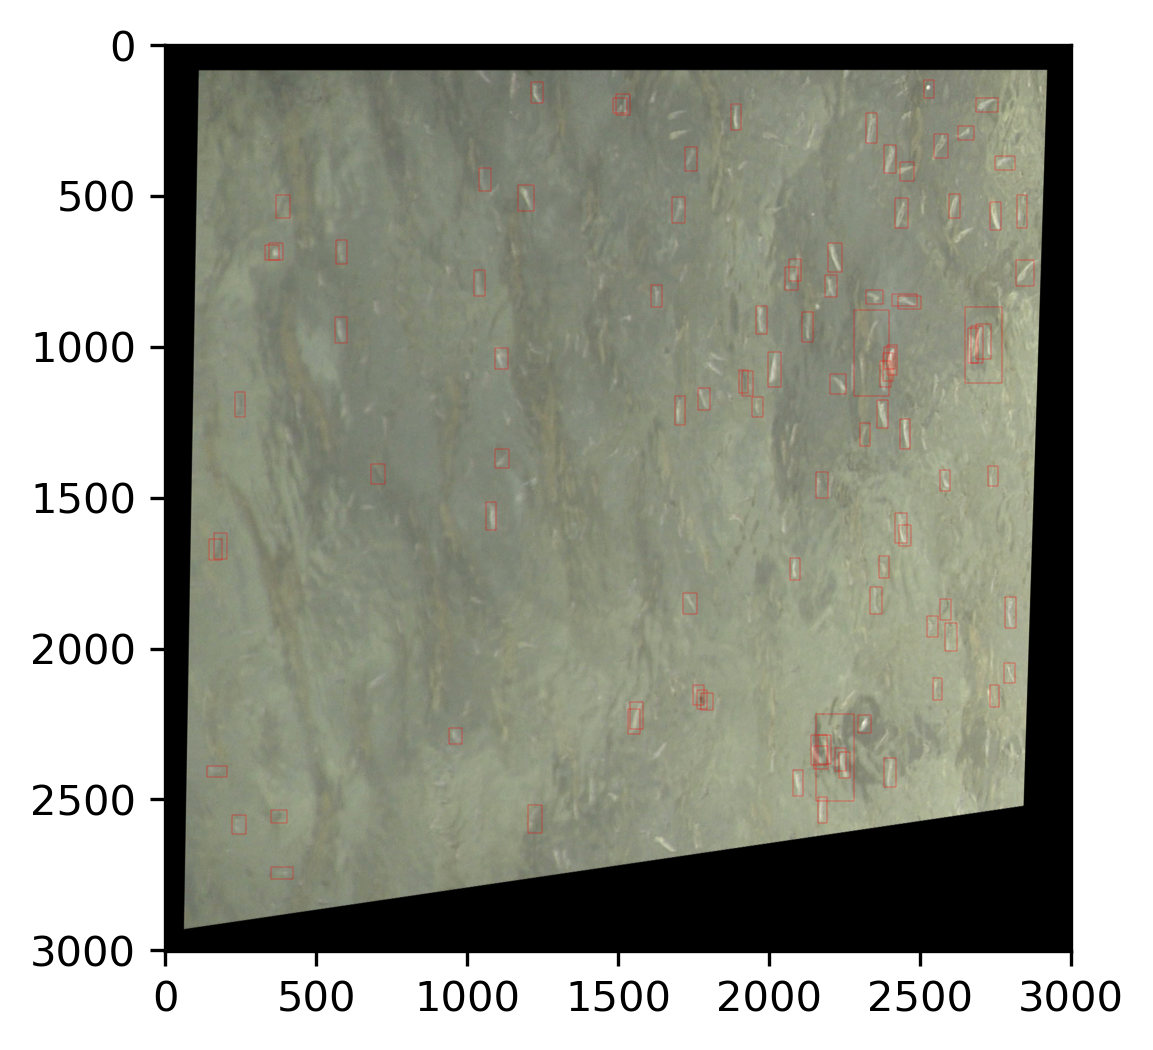

In [37]:
random_img = rd.sample(unlabeled_img, 1)[0]

transformed_img = ut.load_transform_image(random_img, resize=3002)

prediction = ut.predict(model, transformed_img)

ut.draw_predictions(transformed_img, prediction, threshold=0.1)

In [ ]:
prediction

In [63]:
# Example: Evaluate on a single training sample
with torch.no_grad():
    sample_img, _ = fish_dataset[202]  # Assuming you have access to your training dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sample_pred = model([sample_img.to(device)])
    # Continue as before to visualize predictions


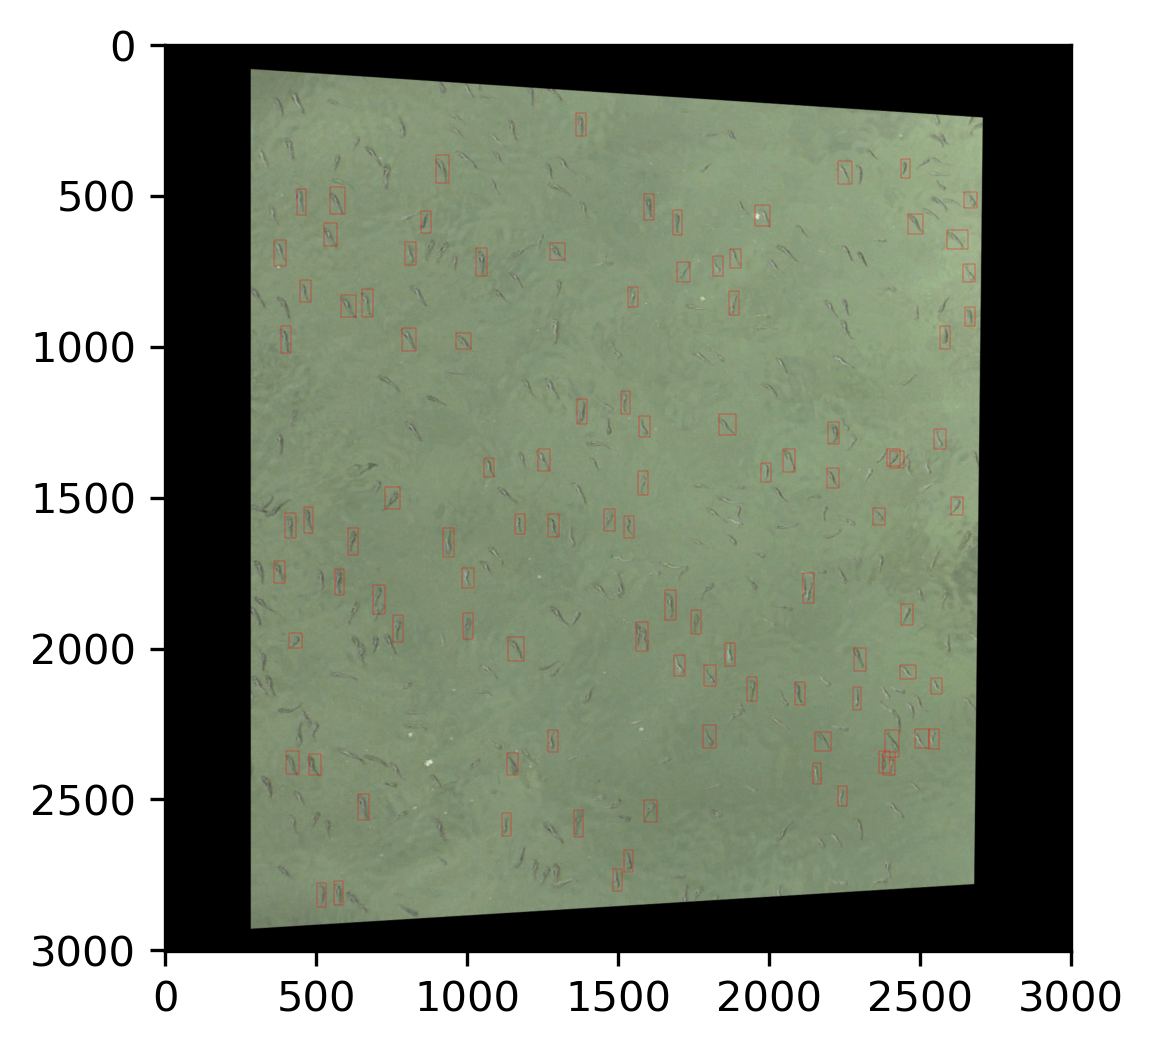

In [68]:
ut.draw_predictions(sample_img, sample_pred, threshold=0)


## Validation

This section is still highly 'work in progress'. Let's start by dividing the dataset in training/validation sets:

In [22]:
num_epochs = 3
batch_size = 4
validation_split = 0.2  # 20% of the dataset will be used for validation

transform = transforms.ToTensor()
fish_dataset = FishDataset(image_annotations, subset_percentage=20, transform=transform)

dataset_size = len(fish_dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(fish_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

Defining a new taining cycle that consider also the validation process

In [23]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.6, weight_decay=0.0005)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    train_loss_list = []
    val_loss_list = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            loss_output = model(images, targets)
            
            if isinstance(loss_output, list):  # Check if the output is a list
                losses = sum(sum(d.values()) for d in loss_output)  # Sum up all losses in the list
            else:
                losses = sum(loss for loss in loss_output.values())
            
            losses.backward()
            optimizer.step()
            
            total_train_loss += losses.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)
        
        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = list(img.to(device) for img in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                loss_output = model(images, targets)
                if isinstance(loss_output, list):
                    losses = sum(sum(d.values()) for d in loss_output)
                else:
                    losses = sum(loss for loss in loss_output.values())
                
                total_val_loss += losses.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}: Avg. Training Loss = {avg_train_loss:.4f}, Avg. Validation Loss = {avg_val_loss:.4f}")
        
        lr_scheduler.step()
    
    return train_loss_list, val_loss_list


Epoch 1/3 - Validation:   0%|          | 0/3 [00:06<?, ?it/s]


RuntimeError: The size of tensor a (4) must match the size of tensor b (100) at non-singleton dimension 1

We can now use the latter training procedure (with validation) to test how the performance of the model varies while we modify the hyperparameters. We are going to perform `Grid Search`, that is look for all the combinations of hyperparameters starting from 'chosed-by-hand' lists.

Training model 1 with lr=0.0005, momentum=0.6, weight_decay=0.0005


Epoch 1/8: 100%|██████████| 68/68 [17:59<00:00, 15.88s/it, loss=1.06]


Epoch 1 Average Loss: 1.0611119033659207


Epoch 2/8: 100%|██████████| 68/68 [18:00<00:00, 15.88s/it, loss=0.775]


Epoch 2 Average Loss: 0.7745624088189181


Epoch 3/8: 100%|██████████| 68/68 [18:02<00:00, 15.91s/it, loss=0.754]


Epoch 3 Average Loss: 0.7535505636649973


Epoch 4/8: 100%|██████████| 68/68 [18:02<00:00, 15.92s/it, loss=0.737]


Epoch 4 Average Loss: 0.7373141703360221


Epoch 5/8: 100%|██████████| 68/68 [17:59<00:00, 15.87s/it, loss=0.733]


Epoch 5 Average Loss: 0.733030716285986


Epoch 6/8: 100%|██████████| 68/68 [17:59<00:00, 15.87s/it, loss=0.736]


Epoch 6 Average Loss: 0.7359934035031235


Epoch 7/8: 100%|██████████| 68/68 [17:56<00:00, 15.83s/it, loss=0.733]


Epoch 7 Average Loss: 0.7329547470983337


Epoch 8/8: 100%|██████████| 68/68 [17:59<00:00, 15.88s/it, loss=0.733]


Epoch 8 Average Loss: 0.7333729150978958
Training complete


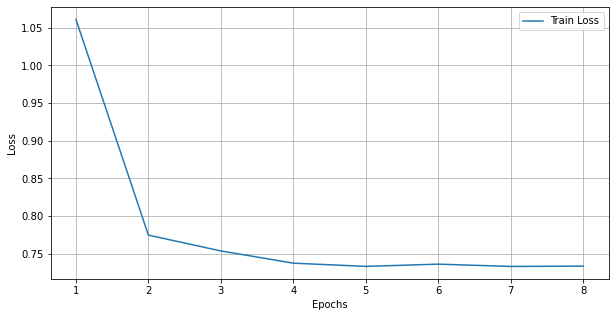

Training model 2 with lr=0.0005, momentum=0.6, weight_decay=0.001


Epoch 1/8: 100%|██████████| 68/68 [17:59<00:00, 15.87s/it, loss=1.05]


Epoch 1 Average Loss: 1.048446639057468


Epoch 2/8: 100%|██████████| 68/68 [18:00<00:00, 15.89s/it, loss=0.782]


Epoch 2 Average Loss: 0.7822877898374024


Epoch 3/8: 100%|██████████| 68/68 [17:57<00:00, 15.85s/it, loss=0.75] 


Epoch 3 Average Loss: 0.7497834181960892


Epoch 4/8: 100%|██████████| 68/68 [17:56<00:00, 15.82s/it, loss=0.739]


Epoch 4 Average Loss: 0.7392468163195778


Epoch 5/8: 100%|██████████| 68/68 [17:57<00:00, 15.84s/it, loss=0.738]


Epoch 5 Average Loss: 0.7376740322831798


Epoch 6/8: 100%|██████████| 68/68 [17:56<00:00, 15.83s/it, loss=0.737]


Epoch 6 Average Loss: 0.7366089923855137


Epoch 7/8: 100%|██████████| 68/68 [17:55<00:00, 15.82s/it, loss=0.733]


Epoch 7 Average Loss: 0.7328150761039818


Epoch 8/8: 100%|██████████| 68/68 [17:57<00:00, 15.84s/it, loss=0.733]


Epoch 8 Average Loss: 0.7330170304459684
Training complete


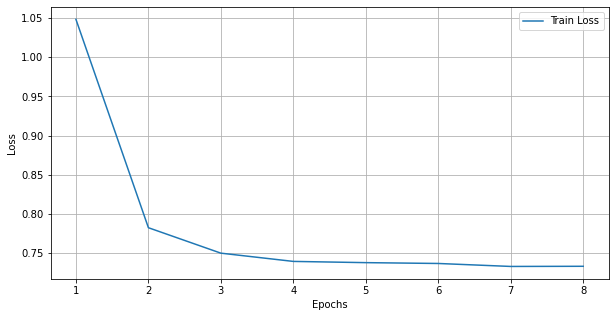

Training model 3 with lr=0.0005, momentum=0.8, weight_decay=0.0005


Epoch 1/8: 100%|██████████| 68/68 [17:56<00:00, 15.84s/it, loss=1.04]


Epoch 1 Average Loss: 1.0404294501332676


Epoch 2/8: 100%|██████████| 68/68 [17:56<00:00, 15.83s/it, loss=0.771]


Epoch 2 Average Loss: 0.7712604839573888


Epoch 3/8: 100%|██████████| 68/68 [17:56<00:00, 15.83s/it, loss=0.744]


Epoch 3 Average Loss: 0.7442392676192171


Epoch 4/8: 100%|██████████| 68/68 [17:54<00:00, 15.79s/it, loss=0.725]


Epoch 4 Average Loss: 0.7253574470386785


Epoch 5/8: 100%|██████████| 68/68 [17:53<00:00, 15.78s/it, loss=0.72] 


Epoch 5 Average Loss: 0.7201316093697268


Epoch 6/8: 100%|██████████| 68/68 [17:55<00:00, 15.81s/it, loss=0.72] 


Epoch 6 Average Loss: 0.7204453410471187


Epoch 7/8: 100%|██████████| 68/68 [17:58<00:00, 15.86s/it, loss=0.721]


Epoch 7 Average Loss: 0.7205102419590249


Epoch 8/8: 100%|██████████| 68/68 [17:57<00:00, 15.84s/it, loss=0.72] 


Epoch 8 Average Loss: 0.7203011841458433
Training complete


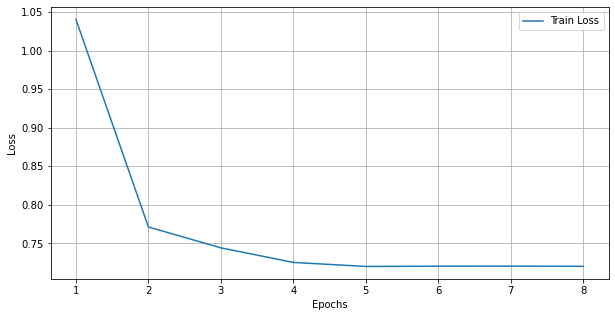

Training model 4 with lr=0.0005, momentum=0.8, weight_decay=0.001


Epoch 1/8: 100%|██████████| 68/68 [17:54<00:00, 15.80s/it, loss=0.987]


Epoch 1 Average Loss: 0.9872925794299912


Epoch 2/8: 100%|██████████| 68/68 [17:55<00:00, 15.81s/it, loss=0.738]


Epoch 2 Average Loss: 0.7378348624881577


Epoch 3/8: 100%|██████████| 68/68 [18:00<00:00, 15.89s/it, loss=0.719]


Epoch 3 Average Loss: 0.7185210800346207


Epoch 4/8: 100%|██████████| 68/68 [17:54<00:00, 15.81s/it, loss=0.697]


Epoch 4 Average Loss: 0.6970811264918131


Epoch 5/8: 100%|██████████| 68/68 [17:54<00:00, 15.80s/it, loss=0.695]


Epoch 5 Average Loss: 0.6948455015526098


Epoch 6/8: 100%|██████████| 68/68 [17:57<00:00, 15.85s/it, loss=0.693]


Epoch 6 Average Loss: 0.6934806555509567


Epoch 7/8: 100%|██████████| 68/68 [17:54<00:00, 15.80s/it, loss=0.689]


Epoch 7 Average Loss: 0.6886500760036356


Epoch 8/8: 100%|██████████| 68/68 [17:55<00:00, 15.82s/it, loss=0.694]


Epoch 8 Average Loss: 0.6941775556872872
Training complete


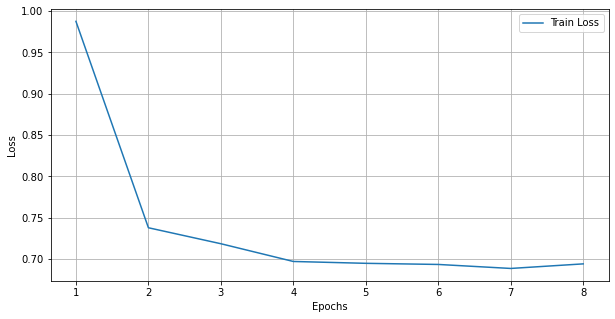

Training model 5 with lr=0.0005, momentum=0.9, weight_decay=0.0005


Epoch 1/8: 100%|██████████| 68/68 [17:55<00:00, 15.82s/it, loss=0.983]


Epoch 1 Average Loss: 0.983320842113565


Epoch 2/8: 100%|██████████| 68/68 [17:55<00:00, 15.82s/it, loss=0.728]


Epoch 2 Average Loss: 0.7276007655788871


Epoch 3/8: 100%|██████████| 68/68 [17:54<00:00, 15.81s/it, loss=0.709]


Epoch 3 Average Loss: 0.7088837702484692


Epoch 4/8: 100%|██████████| 68/68 [17:55<00:00, 15.82s/it, loss=0.691]


Epoch 4 Average Loss: 0.6906616444535115


Epoch 5/8: 100%|██████████| 68/68 [17:56<00:00, 15.83s/it, loss=0.681]


Epoch 5 Average Loss: 0.6809841078870437


Epoch 6/8: 100%|██████████| 68/68 [17:56<00:00, 15.83s/it, loss=0.677]


Epoch 6 Average Loss: 0.6771570062812637


Epoch 7/8: 100%|██████████| 68/68 [17:54<00:00, 15.80s/it, loss=0.678]


Epoch 7 Average Loss: 0.6781544851906159


Epoch 8/8: 100%|██████████| 68/68 [17:55<00:00, 15.81s/it, loss=0.679]


Epoch 8 Average Loss: 0.6789581054712043
Training complete


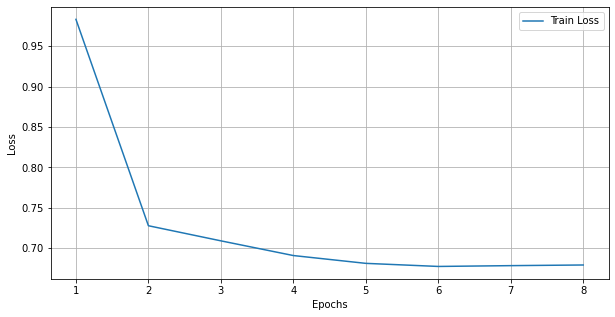

Training model 6 with lr=0.0005, momentum=0.9, weight_decay=0.001


Epoch 1/8: 100%|██████████| 68/68 [17:49<00:00, 15.72s/it, loss=0.966]


Epoch 1 Average Loss: 0.9661742654793403


Epoch 2/8:  31%|███       | 21/68 [05:39<12:38, 16.14s/it, loss=0.82] 


KeyboardInterrupt: 

In [27]:
hyperparameters = {
    'lr': [0.0005, 0.001, 0.005],
    'momentum': [0.6, 0.8, 0.9],
    'weight_decay': [0.0005, 0.001]
}

transform = transforms.ToTensor()
fish_dataset = FishDataset(image_annotations, subset_percentage=100, transform=transform)
num_epochs = 8

# This will create more than 10 combinations, select the first 10 for your grid search
all_combinations = [[lr, momentum, weight_decay] 
                    for lr in hyperparameters['lr'] 
                    for momentum in hyperparameters['momentum'] 
                    for weight_decay in hyperparameters['weight_decay']][:10]

# loop to iterate over the chosen hyperparameters
for i, (lr, momentum, weight_decay) in enumerate(all_combinations, start=1):
    print(f"Training model {i} with lr={lr}, momentum={momentum}, weight_decay={weight_decay}")
    loss_list= []
    model = get_model(num_classes=2) # Including the background as a class
    train_model(model, fish_dataset, num_epochs, lr, momentum, weight_decay)

    torch.save(model.state_dict(), folder + 'model' + str(i) + '_weights.pth') 

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), loss_list, label='Train Loss')
    #plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.title(f'Fold {fold_idx + 1} - Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
